In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data_collector import Omie

from potenciala import BucketMethod, FigureShape, SingleTimeSeries, VectorTimeSeries
from stochastic import (EulerMaruyama, ConstantDiffusionMultivariate, SpatialDifferenceDriftMultivariate, 
                        SpatialDiffusionUnivariate, SpatialDriftMultivariate)

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")

In [5]:
# filter data before 2004 (missing dates in 2003) and beyond 2021
df = df_raw.query("year >= 2004 & year <= 2020")

### Univariate timeseries

In [6]:
s_1 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

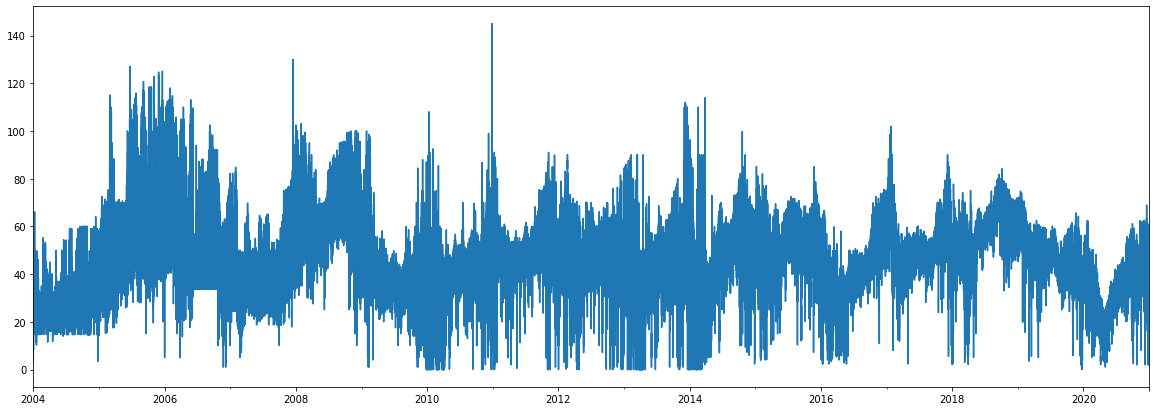

In [7]:
s_1.plot_ts()

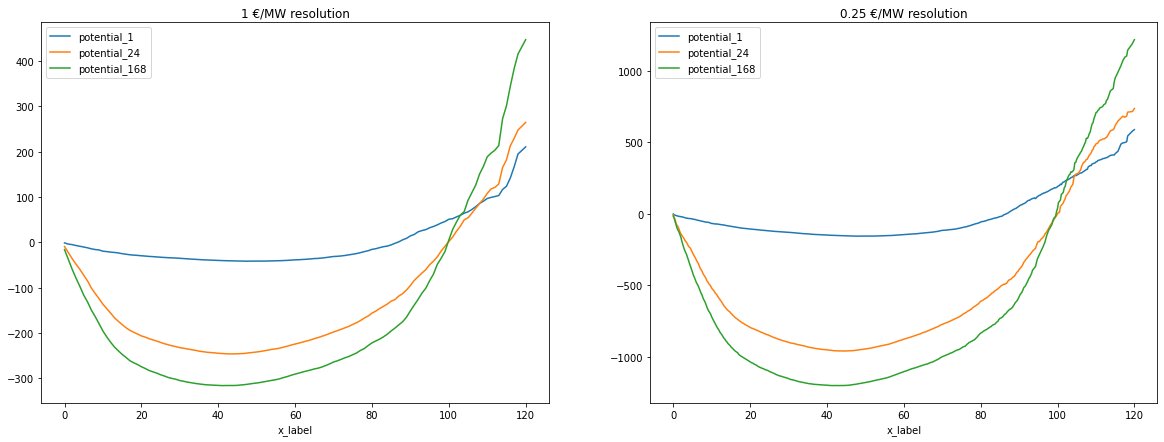

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

### Include all history or last n years

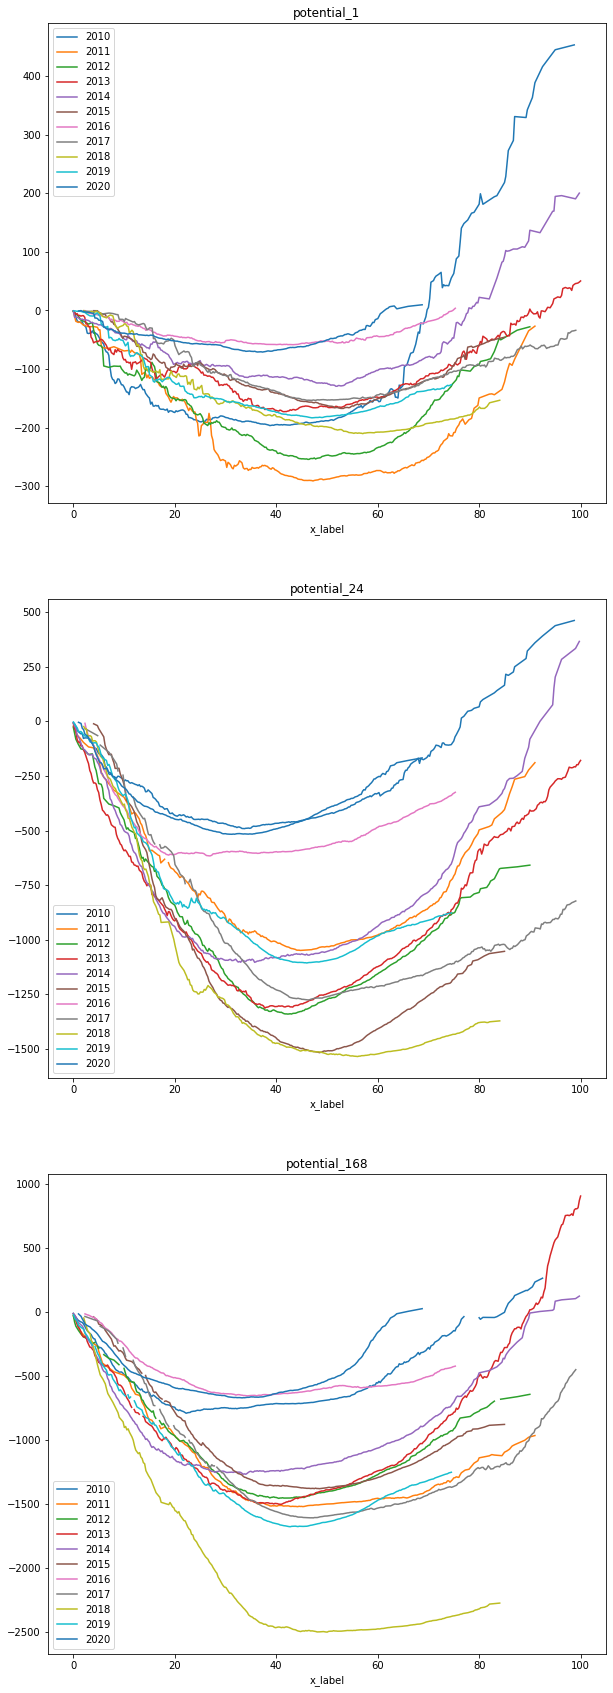

In [9]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

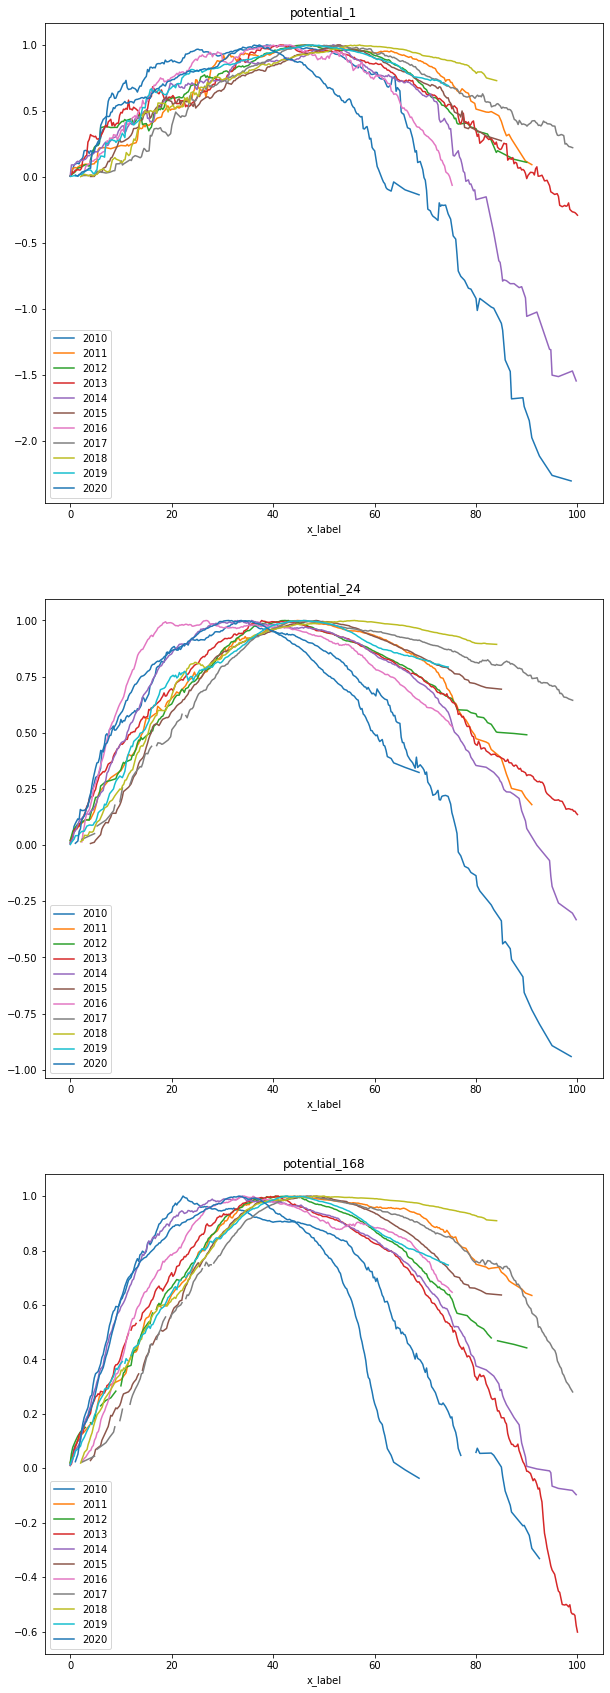

In [10]:
# Compare potential across different years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

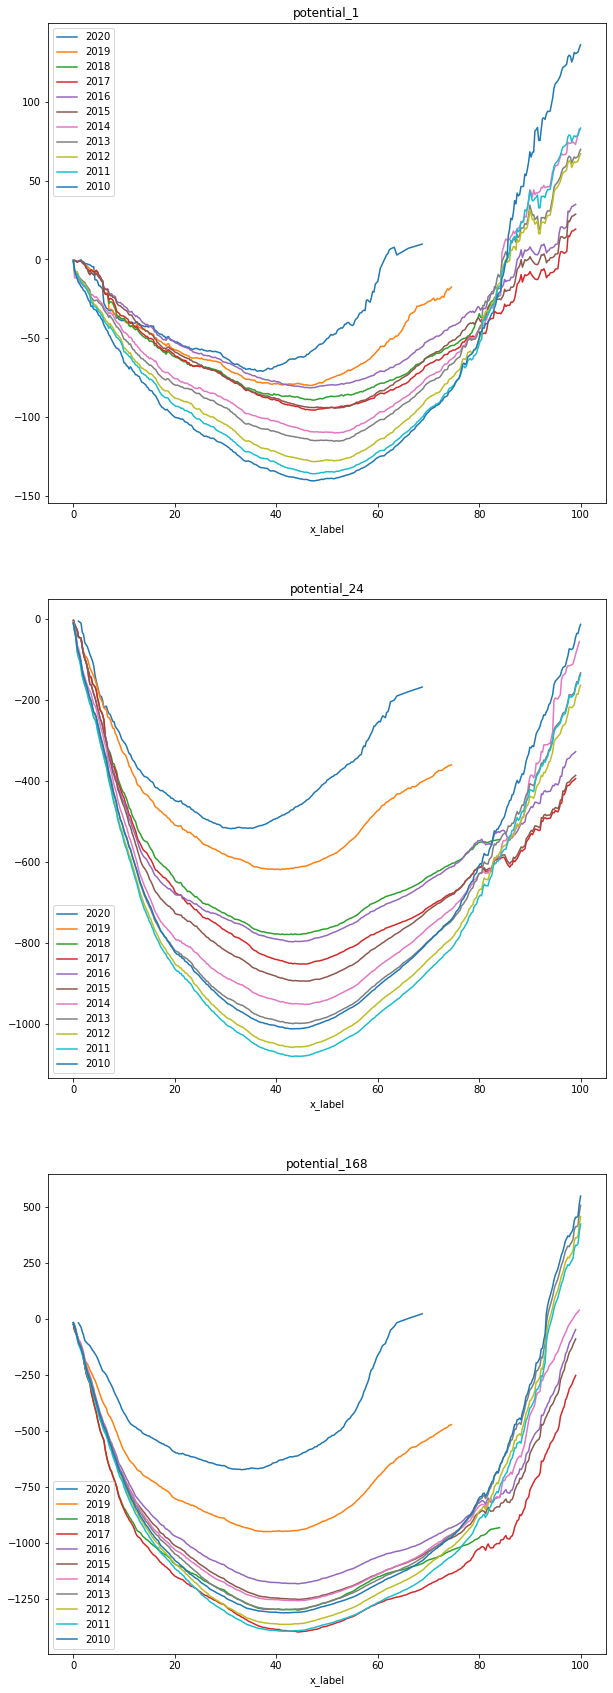

In [11]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

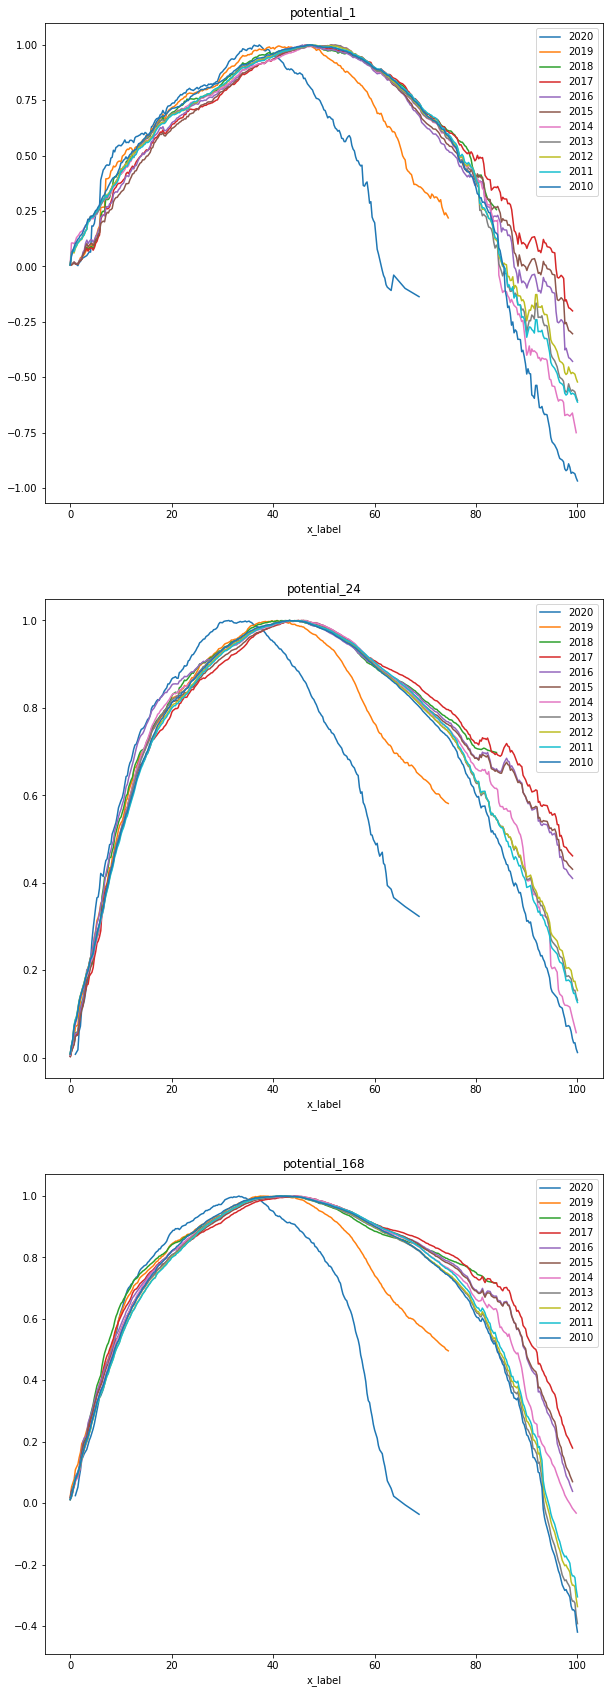

In [12]:
# Compute accumulative years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

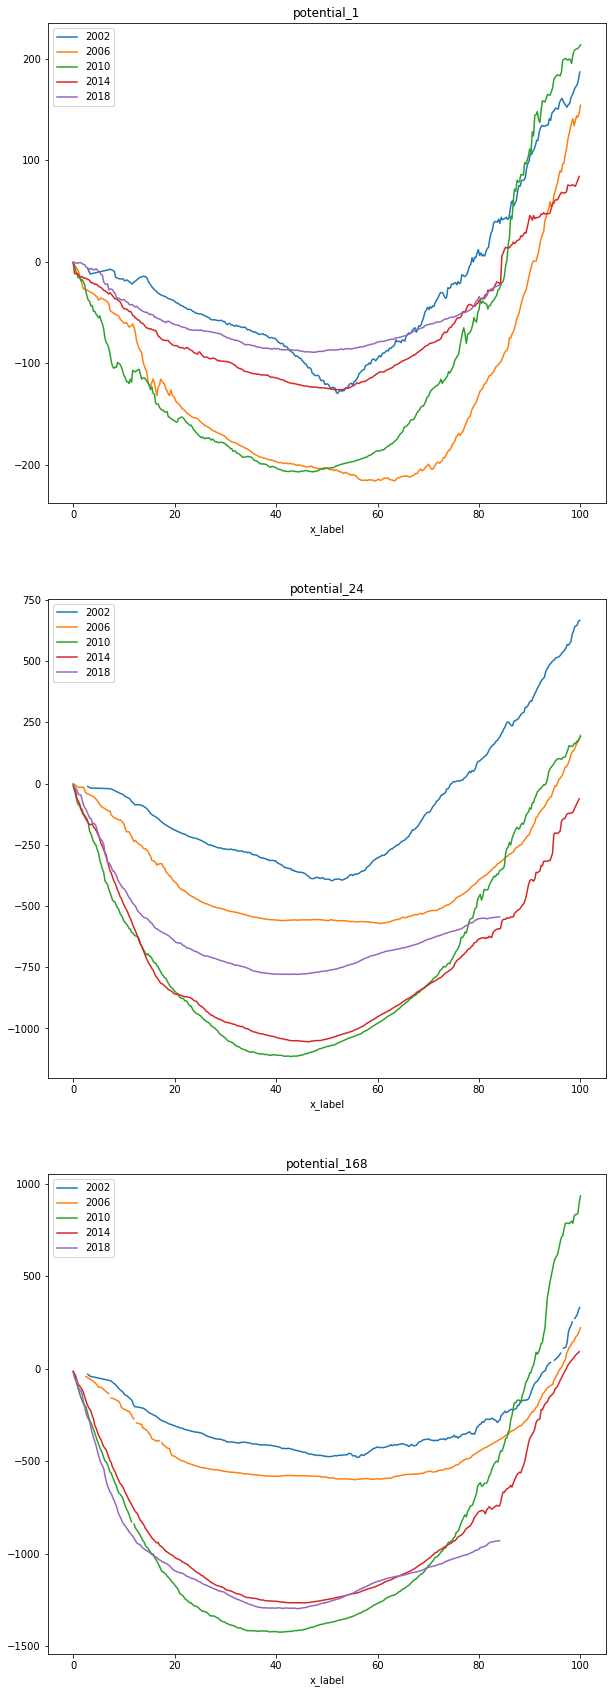

In [13]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

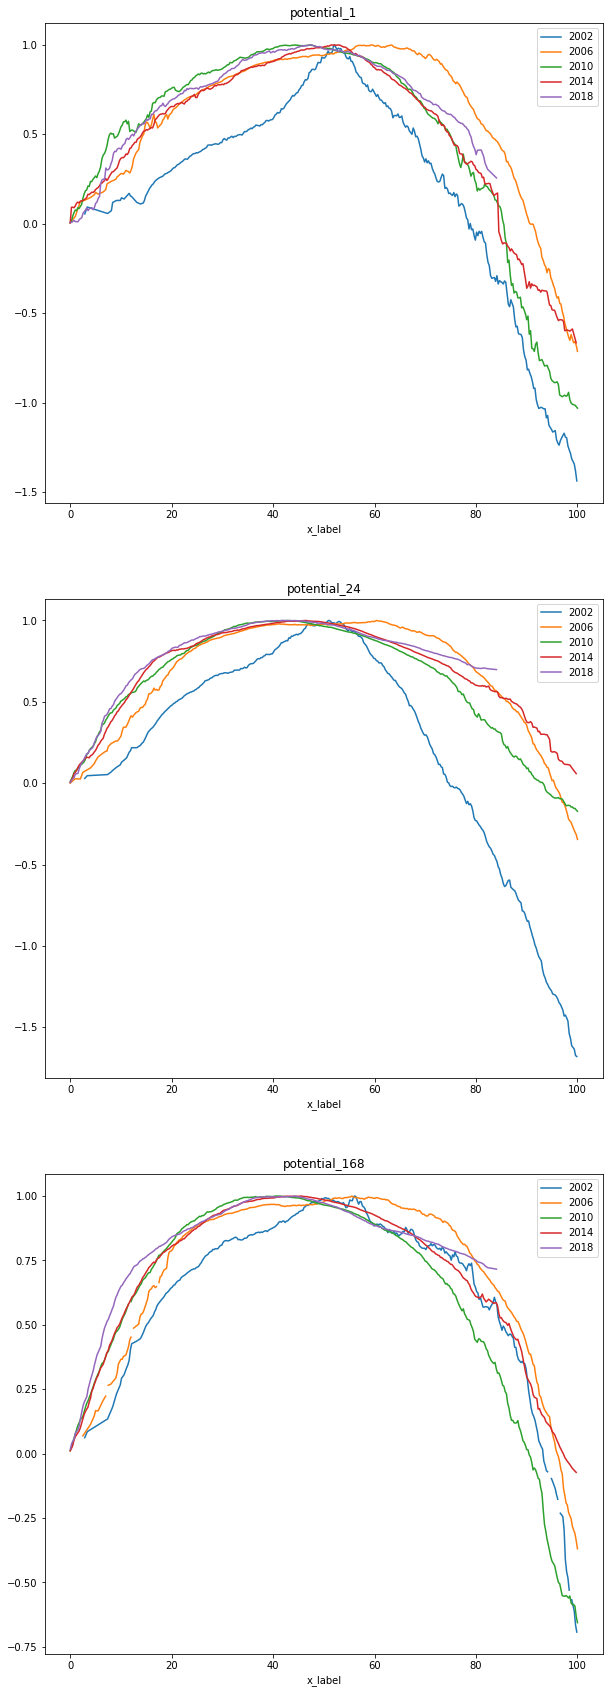

In [14]:
# Check n-year period divided by minimum
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

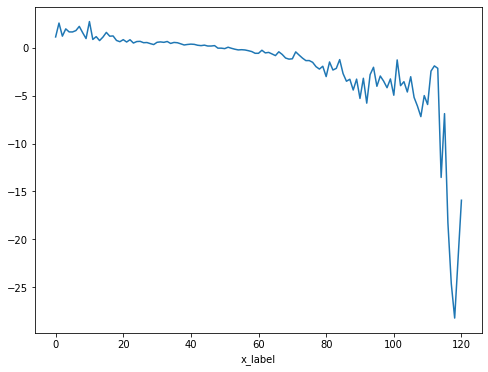

In [15]:
# plot mean drift and diffusion
_ = s_1.drift.mean["drift_1"].iloc[:120].plot()

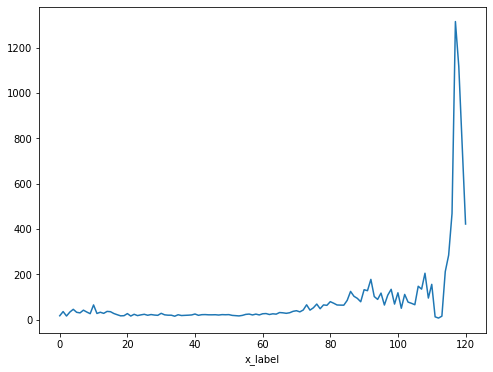

In [16]:
_ = s_1.diffusion.mean["diffusion_1"].iloc[:120].plot()

In [17]:
a = s_1.drift.mean["drift_1"]
a = a.reindex(np.arange(0, a.index.max() + 20)).fillna(0)
b = s_1.diffusion.mean["diffusion_1"]
b = b.reindex(np.arange(0, b.index.max() + 20)).fillna(0)

x_df = s_1.df[(s_1.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[0]

In [18]:
drift = SpatialDriftMultivariate(df=a.to_frame())
diffusion = SpatialDiffusionUnivariate(df=b.to_frame())

em_1 = EulerMaruyama(num_sim=1000, period=24*6, delta_t=1, nu=0, drift=drift, diffusion=diffusion)

In [19]:
sim_df = em_1.simulate(x0=np.array([x_0]), random_seed=124)

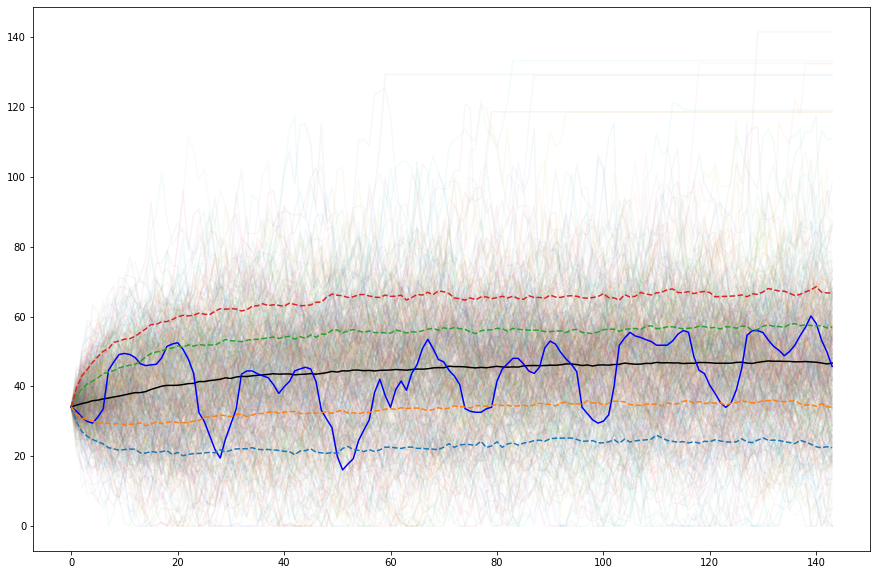

In [20]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[:,  :em_1.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
plt.show()

### Multivariate  timeseries $D_{1}^h(X_{d}^h)$ 

In [21]:
s = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, 
                     diff_matrix_xi_xj_computation=False)

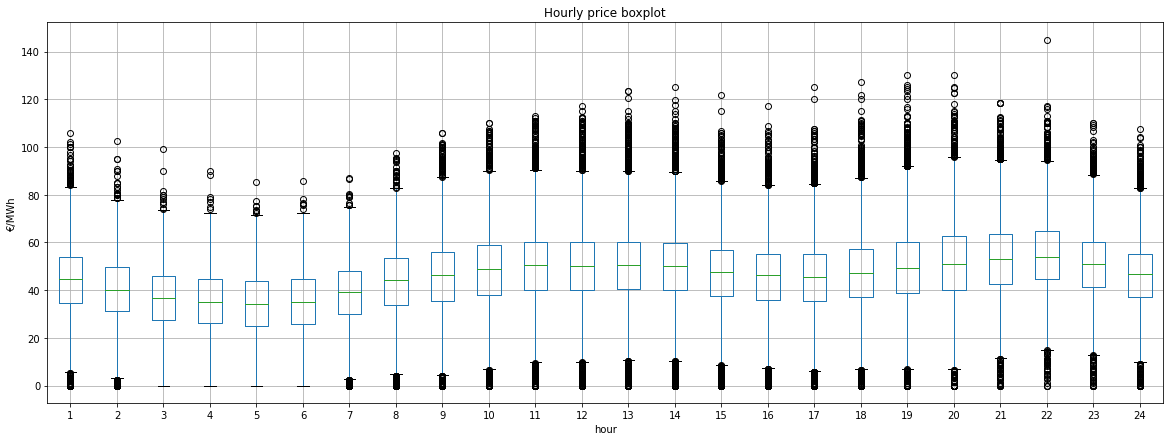

In [22]:
s.plot_hourly_boxplot()

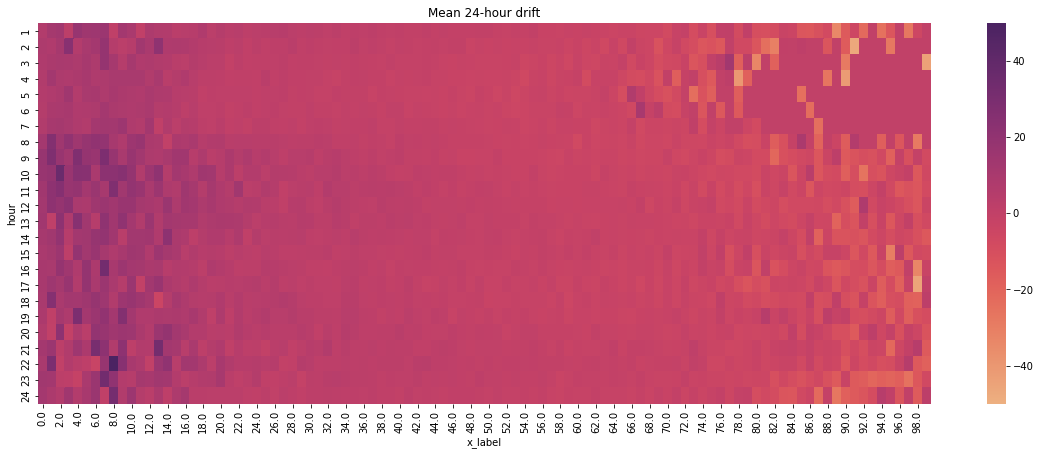

In [23]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.drift_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-50, vmax=50)
ax.set_title("Mean 24-hour drift")
fig.show()

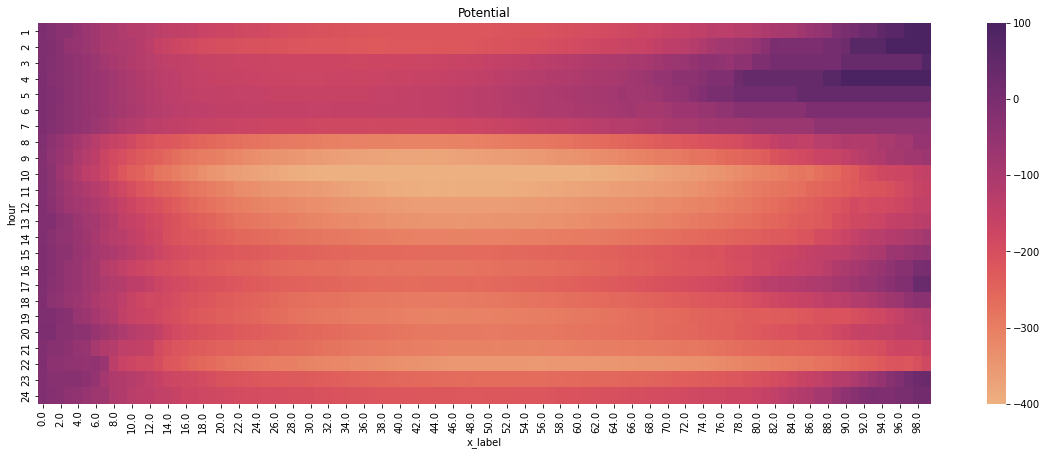

In [24]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.potential_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-400, vmax=100)
ax.set_title("Potential")
fig.show()

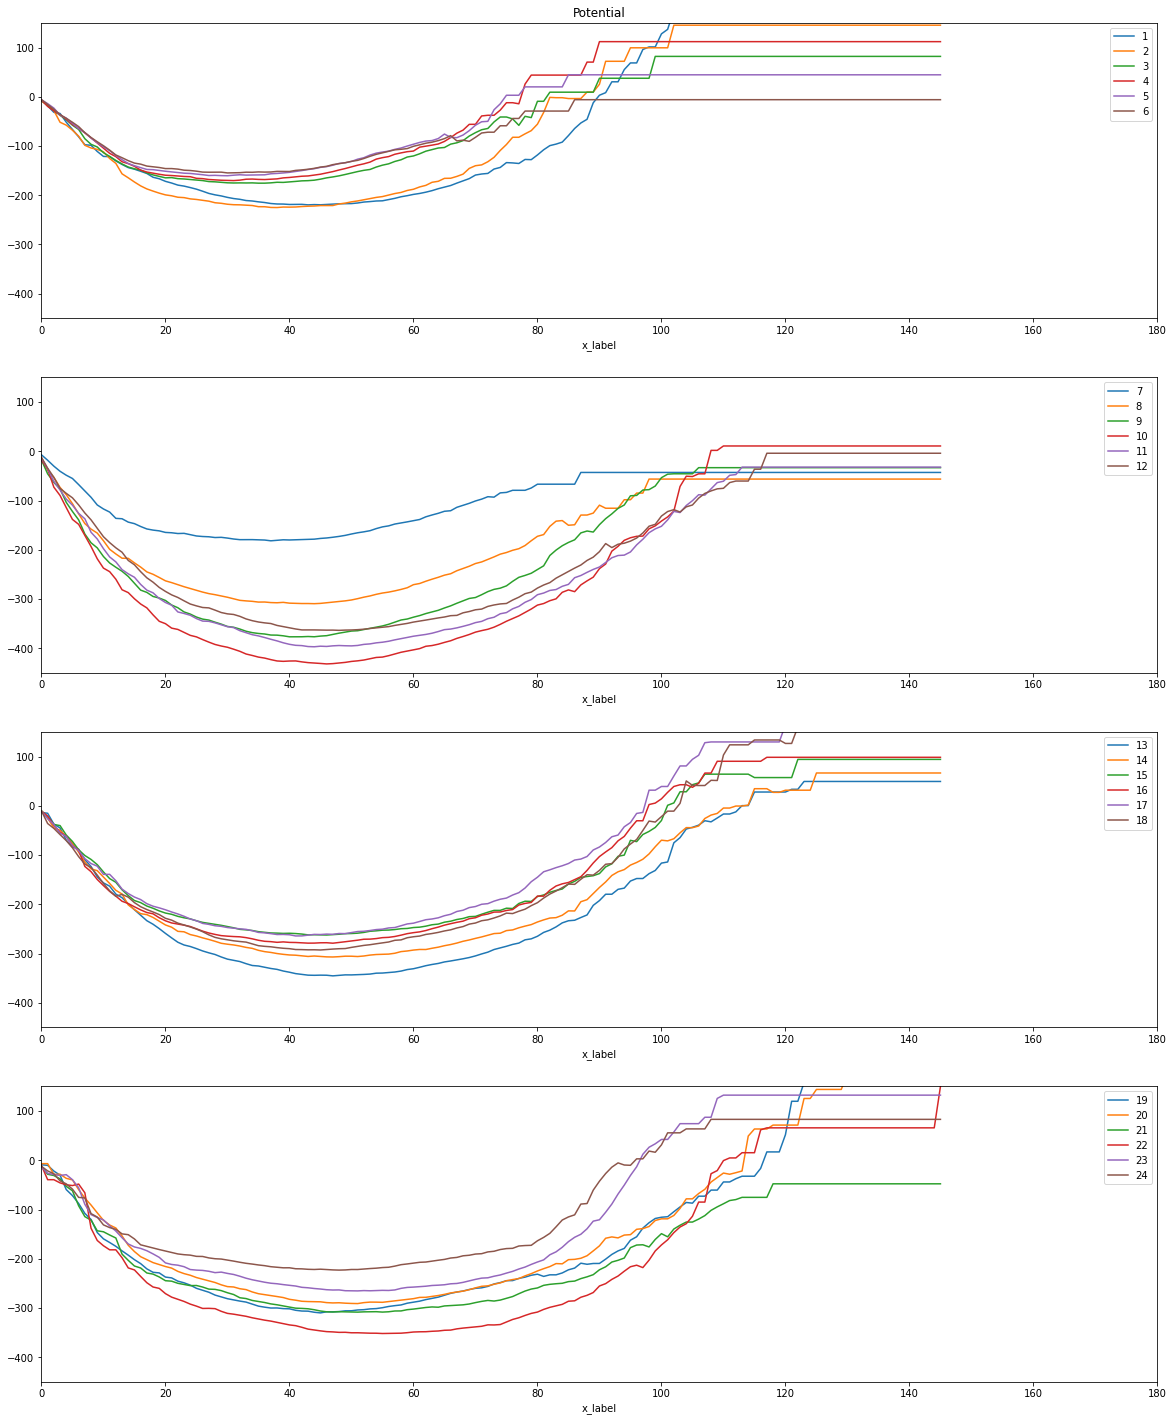

In [25]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(0, 180)
    ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

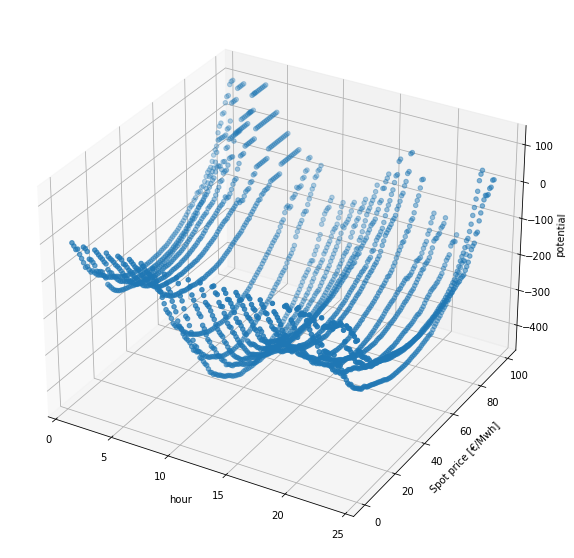

In [26]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s.potential_hour_x.iloc[:, :100].stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("Spot price [€/Mwh]")
ax.set_zlabel("potential")
fig.show()

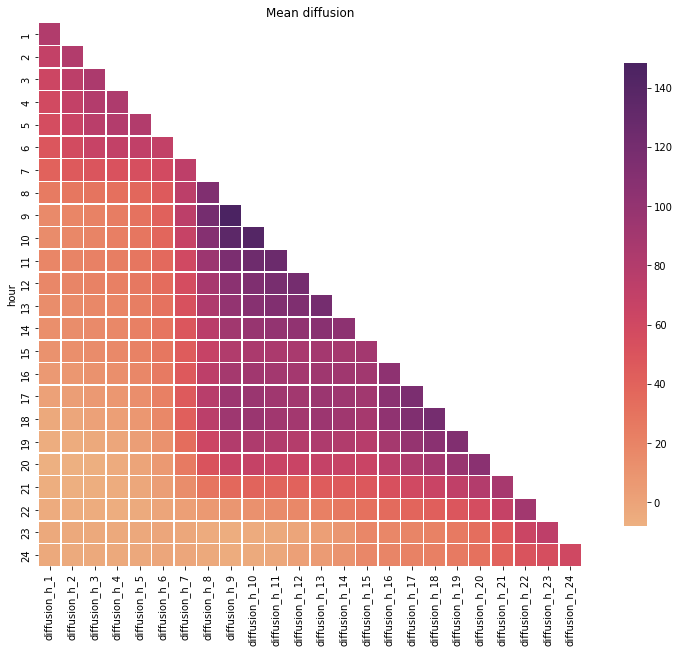

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

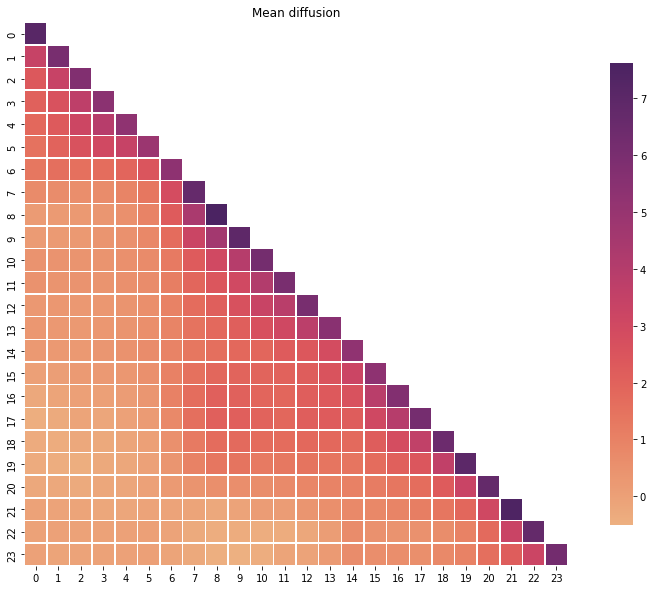

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.sqrt_diff_matrix, dtype=bool), k=1)
sns.heatmap(s.sqrt_diff_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^h(X_{d}^h)$ and diagonal $D^{2}$

In [29]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [30]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
diag_diff_matrix = pd.DataFrame(np.sqrt(np.diag(np.diag(s.diffusion_matrix))))
diag_diffusion = ConstantDiffusionMultivariate(df=diag_diff_matrix)

em_2 = EulerMaruyama(num_sim=1000, period=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=diag_diffusion)

In [31]:
sim_df = em_2.simulate(x0=x_0, random_seed=124)

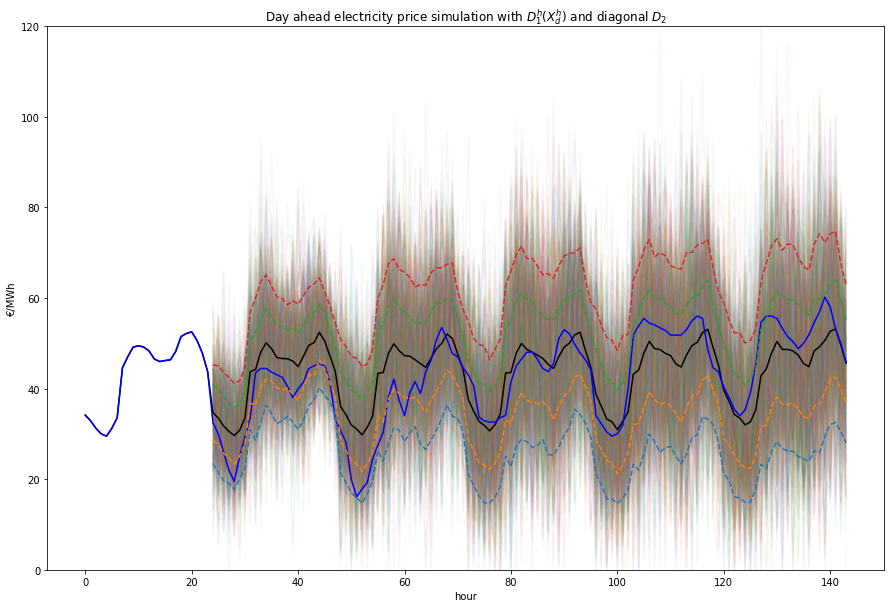

In [32]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_2.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^{h}(X_d^h)$ and diagonal $D_2$")
plt.show()

#### Simulation with $D_{1}^h(X_{d}^h)$ and non-diagonal constant $D^{2}$

In [33]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [34]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s.sqrt_diff_matrix))

em_3 = EulerMaruyama(num_sim=1000, period=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=cte_diffusion)

In [35]:
sim_df = em_3.simulate(x0=x_0, random_seed=124)

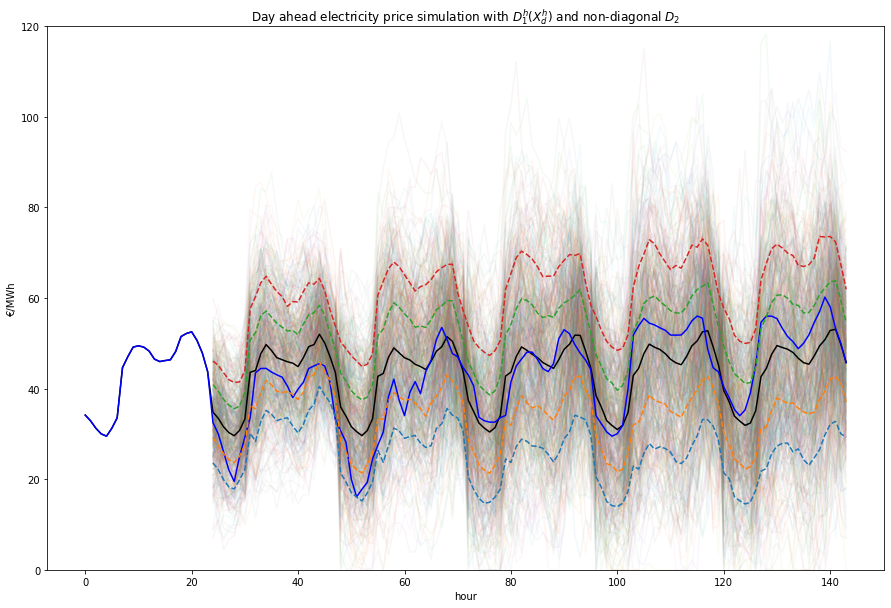

In [36]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_3.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^h(X_d^h)$ and non-diagonal $D_2$")
plt.show()

### Multivariate timeseries  - $D_{1}^{h}(X_{d}^h - X_{d-1}^h)$ 

In [37]:
s_back_drift = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, x_transformation="back_drift")

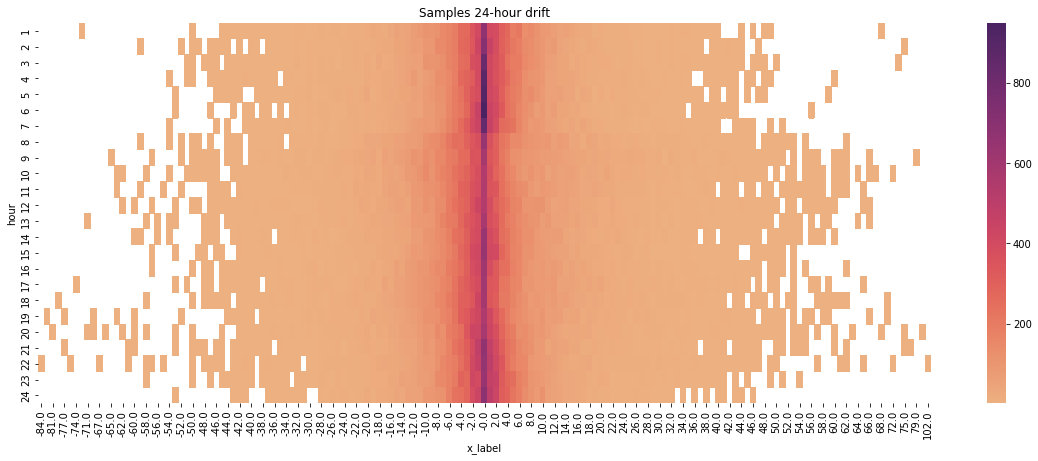

In [38]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.samples_hour_x.iloc[:, :200], ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Samples 24-hour drift")
fig.show()

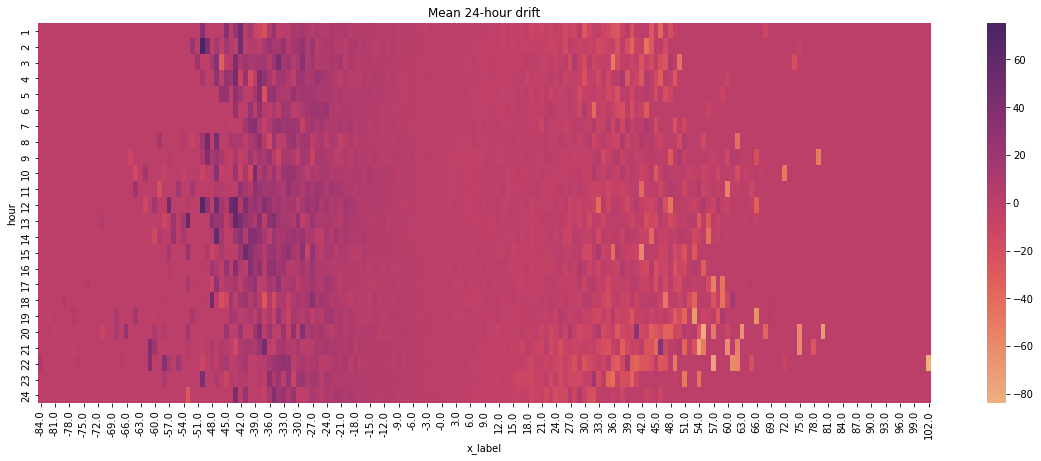

In [39]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.drift_hour_x, ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Mean 24-hour drift")
fig.show()

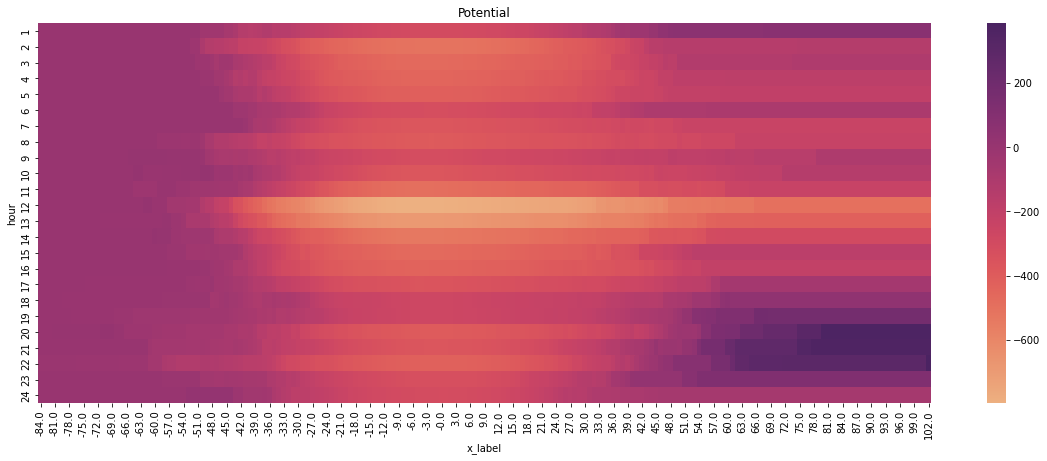

In [40]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.potential_hour_x, ax=ax, cmap='flare')
ax.set_title("Potential")
fig.show()

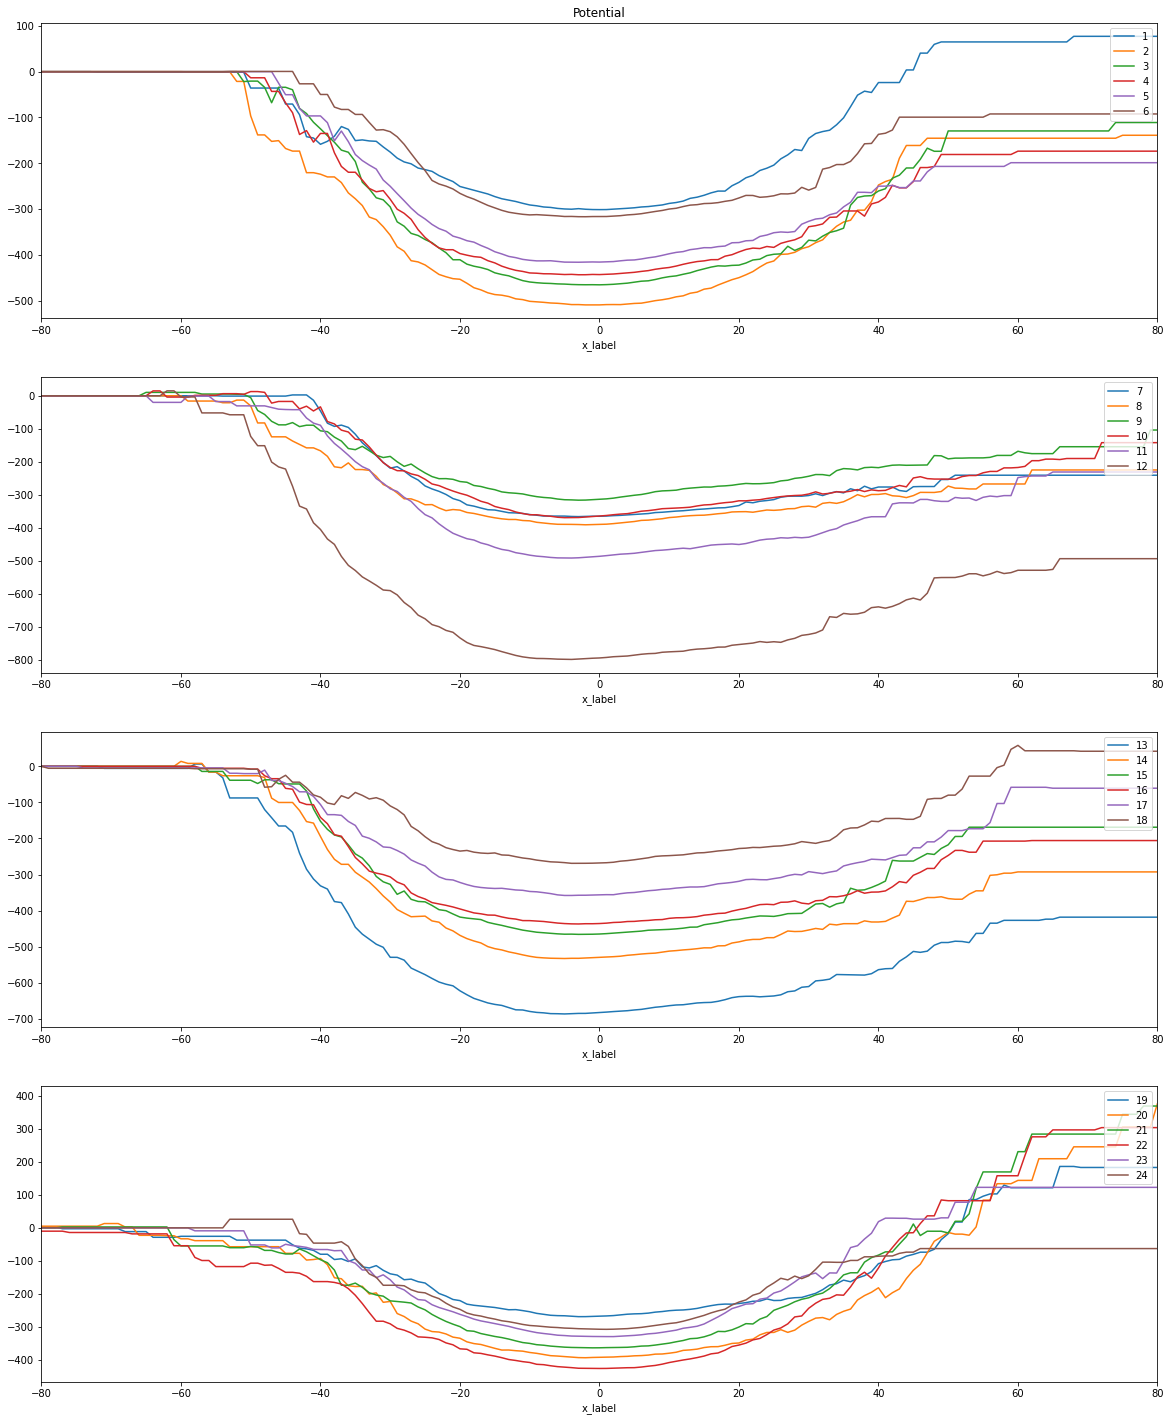

In [41]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s_back_drift.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(-80, 80)
    #ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

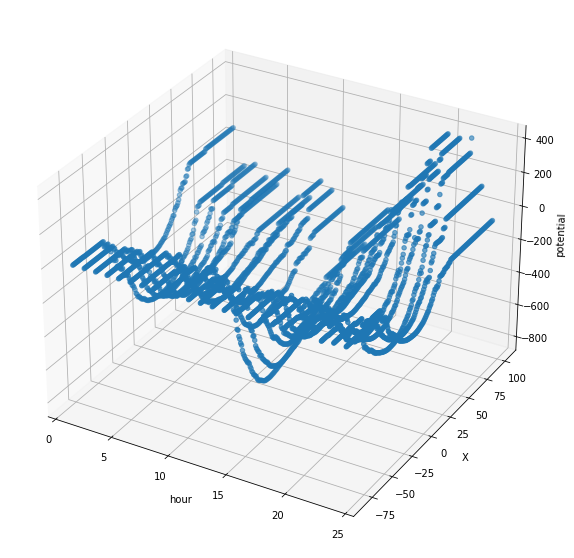

In [42]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s_back_drift.potential_hour_x.stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("X")
ax.set_zlabel("potential")
fig.show()

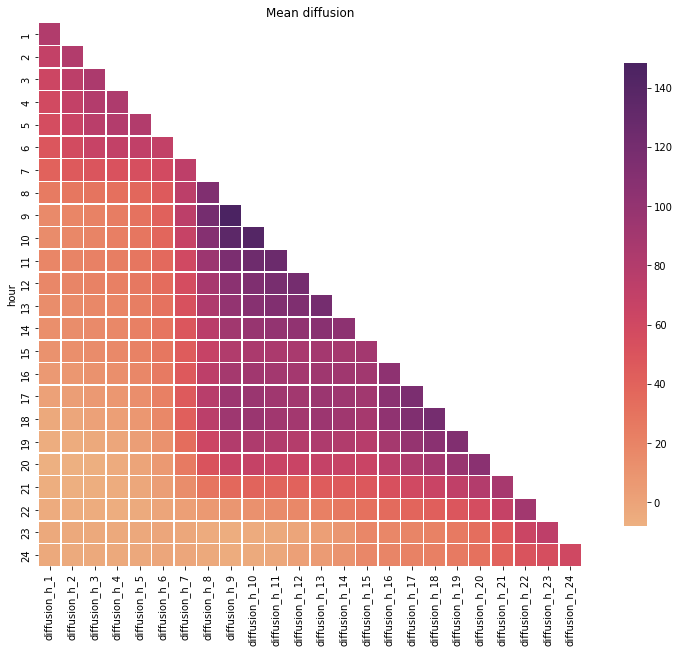

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s_back_drift.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s_back_drift.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^h(X_{d}^h - X_{d-1}^h)$ and non-diagonal constant $D^{2}$

In [44]:
x_df = s_back_drift.df[(s_back_drift.df["date"] >= "2020-12-09")].iloc[:24*7]
t_0 = x_df["spain"].iloc[:24].values
t_1 = x_df["spain"].iloc[24:48].values
x_0 = np.vstack([t_0, t_1]).T

In [45]:
spatial_diff_drift = SpatialDifferenceDriftMultivariate(df=s_back_drift.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s_back_drift.sqrt_diff_matrix))

em_4 = EulerMaruyama(num_sim=1000, period=7, delta_t=1, nu=0, drift=spatial_diff_drift, diffusion=cte_diffusion)

In [46]:
sim_df = em_4.simulate(x0=x_0, random_seed=124)

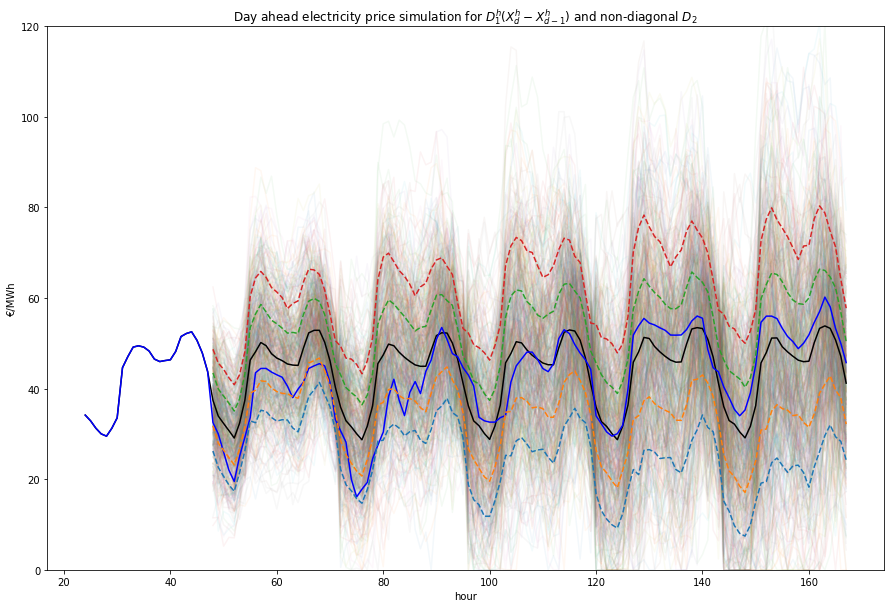

In [47]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[48:, : em_4.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).iloc[24:].plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].iloc[24:].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[48:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation for $D_1^h(X_d^h - X_{d-1}^h)$ and non-diagonal $D_2$")
plt.show()

Compute price inflation as mean daily prices - mean drfit and learn this through a neural ODE